# Problem Statement:

We want to train a simple feedforward neural network to calculate terminal velocity of a solid sphere of density $\sigma$ and radius r, in a liquid of density $\rho$ and viscosity $\eta$.

The formula for this terminal velocity classically is :
$$V_{t} = \frac{2r^{2}(\rho - \sigma)g}{9\eta}$$

Thus there will be 4 inputs into the neural network, densities $\sigma$ and $\rho$, viscosity $\eta$ and radius r. And there will be one output corresponding to the terminal velocity.

We will use above equation to simulate and create data to put into our neural network.


### The twist

We are only allowed to implement this neural network completely from scratch without any external libraries
Only python and numpy allowed (and Matplotlib for plotting purposes)

In [807]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Creating the Data 

Chatgpt suggested these range of values for simulating the data

- > r from 10^-4 to 5 * 10^-3 m
- > $\sigma$ from 500 to 8000 kg/m^3
- > $\rho$ from 700 to 1300 kg/m^3
- > $\eta$ from 0.001 to 2 Pa $\cdot$ s

We will consider 5k input data points into the neural network

In [808]:
dataPoints = 5000

In [809]:
rng = np.random.default_rng(seed = 42)

r = rng.uniform(low = 0.0001, high = 0.005, size = (dataPoints, 1))
perm = rng.permutation(r.shape[0])
r = r[perm]

densSolid = rng.uniform(low = 500, high = 8000, size = (dataPoints, 1))
perm = rng.permutation(densSolid.shape[0])
densSolid = densSolid[perm]

densLiquid = rng.uniform(low = 700, high = 1300, size = (dataPoints, 1))
perm = rng.permutation(densLiquid.shape[0])
densLiquid = densLiquid[perm]

viscosity = rng.uniform(low = 0.001, high = 2, size = (dataPoints, 1))
perm = rng.permutation(viscosity.shape[0])
viscosity = viscosity[perm]

data = np.hstack((r, densSolid, densLiquid, viscosity))

In [810]:
def terminal(dats):
    r, densS, densL, visc = dats
    return (2*(r**2)*(densL - densS)*9.8)/(9*visc)

v = np.apply_along_axis(terminal, 1, data)

## Step 2: Train/test split and Scaling the data

We shall do a 80/20 standard split

We will use Z-score scaling or standardization to scale
We will learn the means and stds from training data and apply same on testing data

We will scale both inputs and outputs since thats necessary for neural networks, and we will unscale the outputs at the end

In [811]:
#Shuffle around the data points

perm = rng.permutation(data.shape[0])
data = data[perm]
v = v[perm]

In [812]:
index = int((0.8) * data.shape[0])

xTrain = data[:index, :]
xTest = data[index: , :]
yTrain = v[:index]
yTest = v[index:]

In [813]:
#Scaling inputs
xMean = np.mean(xTrain, axis = 0)[np.newaxis, :]
xStd = np.std(xTrain, axis = 0)[np.newaxis, :]

xTrain = (xTrain - xMean)/xStd
xTest = (xTest - xMean)/xStd

#Scaling outputs
yMean = np.mean(yTrain)
yStd = np.std(yTrain)
yTestOrig = yTest
yTrainOrig = yTrain

yTrain = (yTrain - yMean)/yStd
yTest = (yTest - yMean)/yStd

In [814]:
yScalingParams = np.array([yMean, yStd])

np.save("./data/xTrain.npy", xTrain)
np.save("./data/xTest.npy", xTest)
np.save("./data/yTrain.npy", yTrain)
np.save("./data/yTest.npy", yTest)
np.save("./data/yTestOrig.npy", yTestOrig)
np.save("./data/yTrainOrig.npy", yTrainOrig)
np.save("./data/yScalingParams.npy", yScalingParams)

## Step 3: Create Base Neural Network Architecture

Each layer requires knowledge of previous layers, as thats how number of weights are decided

The way we will construct this is using 2 classes, one for each layer, and another for the entire model on its own 

Each layer will take number of neurons from previous layer and construct its own weight and bias matrices, randomly of correct size, and we will create a forward function as well

The activation function we will use in this neural network is the ReLU (Rectified Linear Unit)

Important thing to note is that we shouldn't have an activation for our output layer, since our final output (terminal velocity) can and should take any value and shouldn't only be restricted to +ve values (which ReLU would do)

Let's initially consider an architecture where inputs -> layer 1 -> layer 2 -> output

Hidden layer 1 has 12 neurons, and hidden layer 2 has 8 neurons

In [815]:
class Layer:
    #Consider number of neurons in previous layer as x and number of layers in current layer as n
    def __init__(self, x, n):
        self.neurons = n
        
        self.weights = rng.uniform(low = -0.3, high = 0.3, size = (n, x))
        self.bias = rng.uniform(low = -0.1, high = 0.1, size = (n, 1))

        self.activation = np.zeros((n, 1))
        self.preActivation = np.zeros((n, 1))
    
    def ReLU(self, z):
        return np.maximum(0, z)

    #a is the matrix corresponding to the activations of previous layer
    def forward(self, a, hidden):
        self.preActivation = np.matmul(self.weights, a) + self.bias
        self.activation = self.ReLU(self.preActivation) if hidden else self.preActivation
        return self.activation
    
    # Step 4
    def derReLU(self):
        return (self.preActivation > 0).astype(int)

The loss function we will be using is the MSE (Mean Squared Error) loss

In [816]:
l1Neurons = 12
l2Neurons = 8

class NN:
    def __init__(self, Train, Test, learningRate):
        self.l1 = Layer(4, l1Neurons)
        self.l2 = Layer(self.l1.neurons, l2Neurons)
        self.output = Layer(self.l2.neurons, 1)

        self.train = Train.T
        self.test = Test.T
        self.lr = learningRate
    
    def forwardpass(self, input):
        a1 = self.l1.forward(input, 1)
        a2 = self.l2.forward(a1, 1)
        output = self.output.forward(a2, 0)
        return output

    def loss(self, pred, actual):
        return np.mean(((pred - actual) ** 2))
    
    def backwardpass(self):
        #Backpropagation
        input = self.train
        actual = self.test
        nos = self.train.shape[1]

        #For output layer
        outA = 2 * (self.output.activation - actual)
        outW = np.matmul(outA, self.l2.activation.T)/nos
        outB = np.sum(outA, axis = 1, keepdims = True)/nos

        #For hidden layer 2
        l2A = np.matmul(self.output.weights.T, outA)
        l2W = np.matmul(self.l2.derReLU() * l2A, self.l1.activation.T)/nos
        l2B = np.sum(self.l2.derReLU() * l2A, axis = 1, keepdims = True)/nos

        #For hidden layer 1
        l1A = np.matmul(self.l2.weights.T, self.l2.derReLU() * l2A)
        l1W = np.matmul(self.l1.derReLU() * l1A, input.T)/nos
        l1B = np.sum(self.l1.derReLU() * l1A, axis = 1, keepdims = True)/nos

        #Gradient Descent
        self.output.weights -= self.lr * outW
        self.output.bias -= self.lr * outB

        self.l2.weights -= self.lr * l2W
        self.l2.bias -= self.lr * l2B

        self.l1.weights -= self.lr * l1W
        self.l1.bias -= self.lr * l1B
    
    def training(self, epochs, when = 10):
        lossList = []
        for epoch in range(epochs):
            pred = self.forwardpass(self.train)
            self.backwardpass()
            if epoch % when == 0:
                lossList.append(self.loss(pred, self.test))
        return lossList
    
    def testing(self, train, test):
        train = train.T
        test = test.T
        pred = self.forwardpass(train)
        loss = self.loss(pred, test)
        return pred, loss

### Experiment 1: 

We have implemented our basic framework to allow for forwardpass, so let's try our forwardpass on completely random values to set a baseline and to test our code thus far

In [817]:
#nn1 = NN(xTrain, yTrain)
#loss = nn1.testing()

## Step 4: Implement Backpropagation and Gradient Descent

For this we will make changes to the above classes itself

To implement backpropagation, we need to track the gradients

During backpropagation, we multiply by transpose of matrices since we are reversing the mapping.
The maths has been omitted here but has been done to produce the backpropagation function

We need to remember to take mean of derivatives over all samples before gradient descent.

## Step 5: Create Training Loop

Now we create training loop and finally test our made neural network

Easily implemented above


### Experiment 2:

Finally check original loss on test dataset, then train the neural network and check final loss on test dataset

In [818]:
#Creating neural network and checking original loss
nn2 = NN(xTrain, yTrain, 0.02)
pred, loss = nn2.testing(xTest, yTest)

In [819]:
#Training our neural network on defined training datasets
lossList = nn2.training(7500, 50)

In [820]:
pred, loss2 = nn2.testing(xTest, yTest)

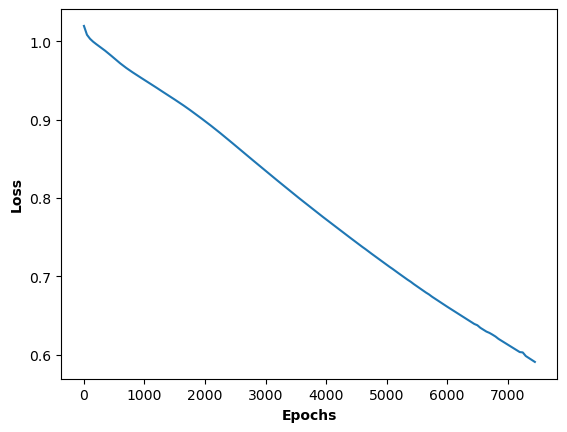

In [821]:
plt.plot(range(0, 7500, 50), lossList)
plt.xlabel("Epochs", weight = "bold")
plt.ylabel("Loss", weight = "bold")
plt.show()

In [822]:
print(f"The percentage improvement in loss of test dataset is {(loss-loss2)*100/loss}")

The percentage improvement in loss of test dataset is 70.03173293198131


## Step 6: Saving model and final validation

We will save this model that we have made, and perform final validation

In [823]:
import pickle
with open("./data/model.pkl", "wb") as f:
    pickle.dump(nn2, f)

In [824]:
xTest = np.load("./data/xTest.npy")
yTest = np.load("./data/yTest.npy")
yTestOrig = np.load("./data/yTestOrig.npy")
yParams = np.load("./data/yScalingParams.npy")

In [825]:
pred, loss = nn2.testing(xTest, yTest)
yMean, yStd = yParams

predActual = pred * yStd + yMean

mae = np.mean(np.abs(predActual - yTestOrig))

print(f"Mean absolute error is {mae}")

Mean absolute error is 0.18717129401599494


In [826]:
a = 169
for i in range(0, 10):
    print(f"Actual: {yTestOrig[a+i]}, Prediction: {predActual[0][a+i]}")

Actual: 0.0004234775334682718, Prediction: -0.001088659189776603
Actual: -0.2170717191957492, Prediction: -0.24133475179453265
Actual: -0.0010809611954877435, Prediction: 0.13023750154259214
Actual: -0.4053801639863159, Prediction: -0.3603190062955082
Actual: -0.006236787785199357, Prediction: 0.019649067365400896
Actual: -0.0015692671483782629, Prediction: 0.08617164679569103
Actual: -0.0669645629325444, Prediction: 0.050328664570988696
Actual: -0.0718166631700495, Prediction: -0.3177933984727401
Actual: -0.037764829447397126, Prediction: 0.09089121427897803
Actual: -0.18333824202285912, Prediction: -0.08238971669386913
